In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os, sys
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
## The dataset
txt_path = "D:\\workspace\\DeepLearning_codes\\AlphaReal\\data.txt"
#df = pd.read_csv(txt_path, sep='\t', lineterminator='\r')
df = pd.read_csv(txt_path, sep='\t')
print(df.head())
#df = df.drop(['Unsold','Completed','Starts'], axis=1)
#print(df.head())

  Date Time     MM  Price_index Unsold  Permits     JS JS_Ratio  Mort_Int  \
0  2003. 11 -0.449       74.180      -     6663 -1.025     56.9      6.04   
1  2003. 12 -0.451       74.578      -    34008 -0.414     56.6      6.28   
2  2004. 01  0.151       74.910      -     1795  0.208     56.6      6.29   
3  2004. 02  0.302       75.242      -     6977  0.622     56.8      6.15   
4  2004. 03  0.301       76.039      -     2171  0.206     57.2      5.98   

  Completed Starts Reg  
0         -      -  GG  
1         -      -  GG  
2         -      -  GG  
3         -      -  GG  
4         -      -  GG  


In [3]:
df.replace({'-': None},inplace =True)
#df['Completed'].replace({'-': None},inplace =True)
df = df.dropna()
df['Unsold'] = df['Unsold'].astype(str).astype(int)
df['Completed'] = df['Completed'].astype(str).astype(int)
df['Starts'] = df['Starts'].astype(str).astype(int)
print(df.head())

   Date Time     MM  Price_index  Unsold  Permits     JS JS_Ratio  Mort_Int  \
86  2011. 01  0.426       93.185   22153     3981  2.599     51.7      4.80   
87  2011. 02  0.425       93.916   21028     3459  3.130     52.7      4.86   
88  2011. 03  0.211       94.190   21162     8891  1.879     54.1      4.89   
89  2011. 04  0.000       94.281   19715     9058  0.000     55.1      4.88   
90  2011. 05  0.000       94.464   21303     5776  0.709     55.5      4.90   

    Completed  Starts Reg  
86       4275    1115  GG  
87       3242    3530  GG  
88       6546    4653  GG  
89       3649    5862  GG  
90       1552    5103  GG  


In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [5]:
#d1 = df['MM']
#d2 = df['JS']
d1 = df['Permits']
d2 = df['Starts']
d3 = df['Completed']

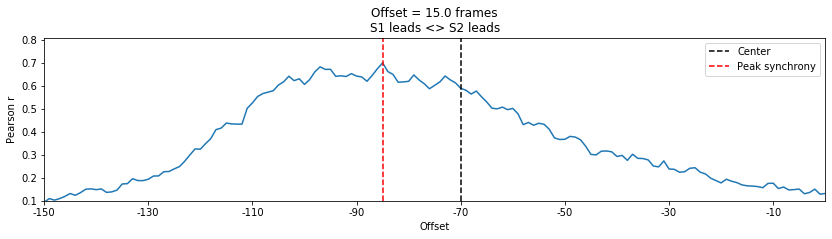

In [15]:
seconds = 4
fps = 20
#rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
rs = [crosscorr(d2,d3, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.81],xlim=[0,150], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);
plt.legend()

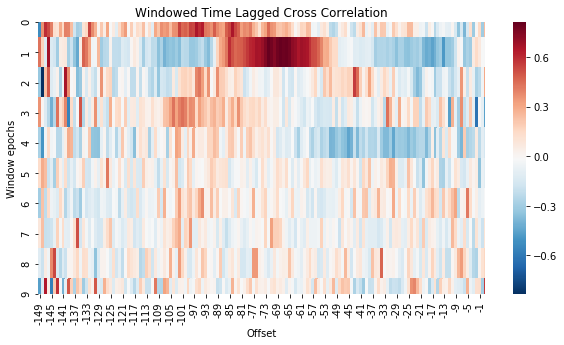

In [24]:
# Windowed time lagged cross correlation
seconds = 4
fps = 20
no_splits = 10
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['Permits'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['Starts'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d3 = df['Completed'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    #rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rs = [crosscorr(d2,d3, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,150], xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

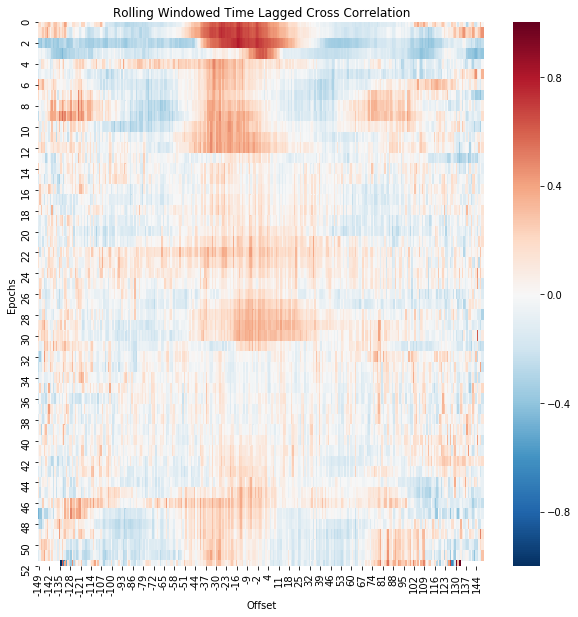

In [31]:
# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 200 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 1800:
    d1 = df['Permits'].iloc[t_start:t_end]
    d2 = df['Starts'].iloc[t_start:t_end]
    d3 = df['Completed'].iloc[t_start:t_end]
    #rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rs = [crosscorr(d2,d3, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);